In [36]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
#import tensorflow.keras
from tensorflow.keras import backend as K

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3




from skimage.transform import resize
from imgaug import augmenters as iaa
 
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


#from tensorflow.nn import sigmoid_cross_entropy_with_logits



In [37]:
tf.test.is_gpu_available()

True

In [38]:
tf.test.is_built_with_cuda()

True

## Image Path

In [39]:
path_train_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'

In [40]:
path_test_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'

In [41]:
def get_number_of_files(path, data_name):
    no =  len(os.listdir(path))
    print (f'The {data_name} contains {no} files.')

In [42]:
def get_size_directory(path, data_name):
    size = round(sum([os.path.getsize(f'{path}'+ f'{file}') for file in os.listdir(path)])*(10**-9), 2)
    print (f'The size of the {data_name} is {size} GB.')

In [43]:
print('***TRAIN DATA***')
get_size_directory(path_train_data, 'Training Data')
get_number_of_files(path_train_data, 'Training Data')

print('*******')

print('***TEST DATA***')
get_size_directory(path_test_data, 'Testing Data')
get_number_of_files(path_test_data, 'Testing Data')

print('*******')

print(f'We have {round(len(os.listdir(path_train_data))/len(os.listdir(path_test_data)),1)} times more train than test data.' )

***TRAIN DATA***
The size of the Training Data is 395.19 GB.
The Training Data contains 752803 files.
*******
***TEST DATA***
The size of the Testing Data is 63.64 GB.
The Testing Data contains 121232 files.
*******
We have 6.2 times more train than test data.


## Meta Data

In [44]:

train_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
# Test submission as test 
test_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')

In [45]:
train_meta_df_shape = train_meta_df.shape
test_meta_df_shape = test_meta_df.shape

In [46]:
print(train_meta_df_shape)
print(test_meta_df_shape)

(4516842, 2)
(727392, 2)


## Parameters

In [65]:

# Seed
SEED = 11
np.random.seed(SEED)


# Constants
TEST_SIZE = 0.02
HEIGHT = 256 #VGG 16 has 256x256
WIDTH = 256
CHANNELS = 3
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 8
SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Folders
#DATA_DIR = '/kaggle/input/rsna-intracranial-hemorrhage-detection/'
PATH_TEST_DATA = path_test_data
PATH_TRAIN_DATA = path_train_data

In [66]:
def set_manual_window(hu_image, min_value, max_value):
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = min_value #max_value
    return hu_image

def rescale_window(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    brain_img = set_manual_window(rescaled_image, 40, 80)
    subdural_img = set_manual_window(rescaled_image, 80, 200)
    soft_img =set_manual_window(rescaled_image, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

def load_dicom_dataset(path, SHAPE):
    dataset = pydicom.dcmread(path)
    try:
        img = rescaled_window(dataset)
    except:
        img = np.zeros(SHAPE)
    return img

In [49]:
    
        
# Generators
class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, labels, batch_size = 16, img_size = SHAPE, img_dir = PATH_TRAIN_DATA, augment = False, *args, **kwargs):
        self.dataset = dataset
        self.ids = dataset.index
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.augment = augment
        self.on_epoch_end()

    def __len__(self): #Number of Batches per Epoch
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index): #Generates one Batch of Data
        #indices of Batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(indices)
        return X, Y

    def augmentor(self, image):
        augment_img = iaa.Sequential([ iaa.Fliplr(0.25),
                                iaa.Flipud(0.10)], random_order = True)       
            
        image_aug = augment_img.augment_image(image)
        return image_aug

    def on_epoch_end(self): #Updates Indices after each Epoch
        self.indices = np.arange(len(self.ids))
        np.random.shuffle(self.indices)

    def __data_generation(self, indices): #Generates Data in Size of Batch Size
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            
            image = load_dicom_dataset(self.img_dir+ID+".dcm", SHAPE)
            if self.augment:
                X[i,] = self.augmentor(image)
            else:
                X[i,] = image
            Y[i,] = self.labels.iloc[index].values        
        return X, Y
    


   
    
    


In [50]:
class TestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset,batch_size = 16, img_size = SHAPE, img_dir = PATH_TEST_DATA, *args, **kwargs):
        self.dataset = dataset
        self.ids = dataset.index
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indices)
        return X

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            image = load_dicom_dataset(self.img_dir+ID+".dcm", SHAPE)
            X[i,] = image              
        return X


## Preparing Meta Data Frames


In [51]:
def make_usable_df(df):
    label = df.Label.values
    new_df = df.ID.str.rsplit("_", n=1, expand=True)
    new_df.loc[:, "label"] = label
    new_df = new_df.rename({0: "id", 1: "subtype"}, axis=1)
    piv_df = pd.pivot_table(new_df, index="id", columns="subtype", values="label")
    
    return piv_df


Check for Dupicates:

In [52]:
train_meta_df.duplicated().sum()

24

In [53]:
train_meta_df.drop_duplicates(inplace = True)

In [54]:
train_meta_df_shape[0] - train_meta_df.shape[0] == 24

True

Make usable Data Frame:

In [55]:
train_df = make_usable_df(train_meta_df)
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0



Check for Duplicates:

In [56]:
test_meta_df.duplicated().sum()

0

Make usable Data Frame:

In [57]:
test_df = make_usable_df(test_meta_df)
test_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0.5,0.5,0.5,0.5,0.5,0.5
ID_000009146,0.5,0.5,0.5,0.5,0.5,0.5
ID_00007b8cb,0.5,0.5,0.5,0.5,0.5,0.5
ID_000134952,0.5,0.5,0.5,0.5,0.5,0.5
ID_000176f2a,0.5,0.5,0.5,0.5,0.5,0.5


# Train/ Val Split

## Multi Label Stratified Shuffel Splitter 
Cross Validaor with stratification on multiple labels:
https://github.com/trent-b/iterative-stratification

In [58]:
msss = MultilabelStratifiedShuffleSplit(n_splits = 10, test_size = TEST_SIZE, random_state = SEED)
X = train_df.index
Y = train_df[['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural']].values

# Get train and test index
msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
valid_idx = msss_splits[1]

In [59]:
train_idx.shape

(737746,)

In [60]:
valid_idx.shape

(15057,)

In [102]:
train_df.index

Index(['ID_000012eaf', 'ID_000039fa0', 'ID_00005679d', 'ID_00008ce3c',
       'ID_0000950d7', 'ID_0000aee4b', 'ID_0000ca2f6', 'ID_0000f1657',
       'ID_000178e76', 'ID_00019828f',
       ...
       'ID_ffff59a97', 'ID_ffff5a8be', 'ID_ffff639f4', 'ID_ffff73ede',
       'ID_ffff80705', 'ID_ffff82e46', 'ID_ffff922b9', 'ID_ffffb670a',
       'ID_ffffcbff8', 'ID_fffff9393'],
      dtype='object', name='id', length=752803)

In [61]:

# # Oversampling
# epidural_df = train_df[train_df.Label['epidural'] == 1]
# train_oversample_df = pd.concat([train_df, epidural_df])
# train_df = train_oversample_df

# # Summary
# print('Train Shape: {}'.format(train_df.shape))
# print('Test Shape: {}'.format(test_df.shape))

## Custom Loan Functions

In [62]:
def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)



## Make Model


In [63]:
SHAPE

(256, 256, 3)

In [67]:
def create_model():
    #K.clear_session()
    
    base_model = VGG19(weights = "imagenet", include_top=False, input_shape = SHAPE)
    #base_model.load_weights(filepath+'model.h5')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    y_pred = Dense(6, activation="sigmoid")(x)

    return Model(inputs = base_model.input, outputs = y_pred)

In [68]:

# Create Data Generators for Train and Valid
data_generator_train = TrainDataGenerator(train_df.iloc[train_idx], 
                                            train_df.iloc[train_idx], 
                                            TRAIN_BATCH_SIZE, 
                                            SHAPE,
                                            augment = True)
data_generator_val = TrainDataGenerator(train_df.iloc[valid_idx], 
                                        train_df.iloc[valid_idx], 
                                        VALID_BATCH_SIZE, 
                                        SHAPE,
                                        augment = False)

TRAIN_STEPS = int(len(data_generator_train) / TRAIN_BATCH_SIZE)

#Adding custom Layers 



vgg19_model = create_model()

for layer in vgg19_model.layers[:5]:
    layer.trainable = False



my_callbacks = [EarlyStopping(monitor='val_accuracy', patience=5),
             ModelCheckpoint(filepath='../models/mymodels/vgg19_1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)]


# compile the model 
vgg19_model.compile(loss =  weighted_loss, optimizer = "adam", metrics=["accuracy"])


        




# Train the model 
history = vgg19_model.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = TRAIN_STEPS,
                        epochs = 50,
                        callbacks = my_callbacks,
                        verbose = 1,
                         use_multiprocessing = True)


Epoch 1/50
179/180 [============================>.] - ETA: 1s - loss: 0.2897 - accuracy: 0.5781
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to ../models/mymodels/vgg19_1.h5
180/180 [==============================] - 421s 2s/step - loss: 0.2898 - accuracy: 0.5787 - val_loss: 0.2336 - val_accuracy: 1.0000
Epoch 2/50
179/180 [============================>.] - ETA: 1s - loss: 0.2486 - accuracy: 0.7918
Epoch 00002: val_accuracy did not improve from 1.00000
180/180 [==============================] - 419s 2s/step - loss: 0.2483 - accuracy: 0.7923 - val_loss: 0.2332 - val_accuracy: 1.0000
Epoch 3/50
179/180 [============================>.] - ETA: 1s - loss: 0.2552 - accuracy: 0.8942
Epoch 00003: val_accuracy did not improve from 1.00000
180/180 [==============================] - 414s 2s/step - loss: 0.2555 - accuracy: 0.8942 - val_loss: 0.2344 - val_accuracy: 1.0000
Epoch 4/50
179/180 [============================>.] - ETA: 1s - loss: 0.2435 - accuracy: 0.9414
Epoch 0

In [35]:
vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

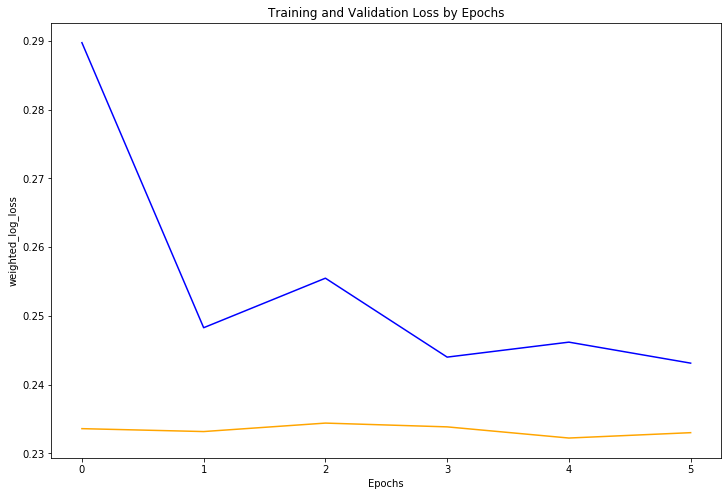

In [69]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss');

In [70]:
# def predictions(test_df, model):    
#     test_preds = model.predict_generator(TestDataGenerator(test_df,TEST_BATCH_SIZE, SHAPE, PATH_TEST_DATA, verbose = 1))
#     return test_preds[:test_df.iloc[range(test_df.shape[0])].shape[0]]


In [70]:
data_generator_test = TestDataGenerator(dataset = test_df, batch_size = TEST_BATCH_SIZE,img_size = SHAPE,
                                                        img_dir = PATH_TEST_DATA)

In [71]:
TEST_STEPS = int(len(data_generator_test) / TRAIN_BATCH_SIZE)

In [ ]:
TEST_STEPS = int(dest_df.shape[0] / TRAIN_BATCH_SIZE)

In [79]:
len(data_generator_test)

15154

In [80]:
preds = vgg19_model.predict_generator(generator = data_generator_test, 
                                      #steps = TEST_STEPS,
                                      verbose = 1,
                                      use_multiprocessing=True)

15154/15154 [==============================] - 1119s 74ms/step


In [84]:
preds.shape

(121232, 6)

In [86]:
test_df.shape

(121232, 6)

In [87]:
preds = preds[:test_df.iloc[range(test_df.shape[0])].shape[0]]

In [88]:
def make_df(meta_data_df, predictions):
    df = pd.DataFrame(predictions, columns=meta_data_df.columns, index=meta_data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    return df

In [90]:
test_pred_df = make_df(test_df, preds)

In [91]:
test_pred_df = test_pred_df[['ID','Label']]

In [92]:
test_pred_df.to_csv('../data/output/submissions/submission_model_2.csv', index=False)

In [93]:
test_pred_df.shape

(727392, 2)

In [95]:
val_preds= vgg19_model.predict_generator(generator = data_generator_val, verbose = 1, use_multiprocessing=True)

236/236 [==============================] - 138s 585ms/step


In [96]:
val_preds.shape

(15104, 6)

In [98]:
train_df[valid_idx]

KeyError: "None of [Int64Index([    21,     48,    118,    174,    283,    349,    428,    445,\n               454,    602,\n            ...\n            752328, 752333, 752358, 752454, 752539, 752560, 752592, 752621,\n            752692, 752770],\n           dtype='int64', name='subtype', length=15057)] are in the [columns]"

In [ ]:
val_pred_df = make_df(val_)